# Projeto 3 - Prevendo o Valor da Ação do PETR4

**Grupo:** Enrico Damiani, Antonio Saporiti, João Pedro Ribeiro

**Sala:** Engenharia 2B

# Introdução:

Esse trabalho possui como objetivo prever o valor da ação PETR4. Para tanto, serão utilizados dados do valor do barril de oleo, do dolar perante o real, da ação RDSA e do Ouro dos ultimos 5 anos. Os modelos utilizarão de tecnicas de regressão para alcançar o objetivo do trabalho.

# Desenvolvimento:

* Importando as Bibliotecas Necessárias

In [1]:
import pandas as pd
import numpy as np
import re
import string
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, probplot
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
import random

* Importando os Dados do Excel

In [2]:
PETR4_raw = pd.read_excel (r'PETR4.SA .xltx')

GOLD_raw = pd.read_excel (r'Gold Futures Historical Data.xltx') 
RDS_raw = pd.read_excel (r'RDS-A.xltx') 
OIL_raw = pd.read_excel (r'Crude Oil WTI Futures Historical Data.xltx')
CRD_raw = pd.read_excel (r'USD_BRL Dados Históricos.xltx')

In [3]:
PETR4 = PETR4_raw[['Date', 'Adj Close']]

GOLD = GOLD_raw[['Date', 'Price']]
RDS = RDS_raw[['Date', 'Adj Close']]
OIL = OIL_raw[['Date', 'Price']]
CRD = CRD_raw[['Data', 'Último']]

* Juntando o DataFrame

Para PTR4:

In [4]:
PETR4_RE = PETR4.rename(columns={"Adj Close": "Valor_PETR4"})
PETR4_REDate = PETR4_RE.assign(Date = PETR4_RE.Date.values[::-1])
PETR4_F = PETR4_REDate.assign(Valor_PETR4 = PETR4_REDate.Valor_PETR4.values[::-1])

Para Gold:

In [5]:
GOLD_F = GOLD.rename(columns={"Price": "Valor_GOLD"})

Para RDS:

In [6]:
RDS_RE = RDS.rename(columns={"Adj Close": "Valor_RDS"})
RDS_REDate = RDS_RE.assign(Date = RDS_RE.Date.values[::-1])
RDS_F = RDS_REDate.assign(Valor_RDS = RDS_REDate.Valor_RDS.values[::-1])

Para OIL:

In [7]:
OIL_F = OIL.rename(columns={"Price": "Valor_OIL"})

Para CRD:

In [8]:
CRD_RE = CRD.rename(columns={"Data": "Date","Último": "Valor_CRD" })

NOVO_VALOR = []
for e in CRD_RE["Valor_CRD"]:
    NOVO_VALOR.append(e/10000)
CRD_RE['Valor_CRD'] = NOVO_VALOR

NOVA_DATA = []
for e in CRD_RE['Date']:
    Separado = e.split(".")
    Correto = Separado[2] + "-" + Separado[1] + "-" + Separado[0]
    NOVA_DATA.append(Correto)
CRD_RE['Date'] = NOVA_DATA 

CRD_F = CRD_RE

Selecionando intervalo a ser estudado e alterando o index:

In [9]:
PETR4_F["Date"] == "2014-11-10" #1240
PETR4_F["Date"] == "2019-10-31" #2
PETR4_DATE = PETR4_F.loc[2: 1240].set_index('Date')

GOLD_F["Date"] == "2014-11-10" #1321
GOLD_F["Date"] == "2019-10-31" #5
GOLD_DATE = GOLD_F.loc[5: 1321].set_index('Date')

RDS_F["Date"] == "2014-11-10" #1256
RDS_F["Date"] == "2019-10-31" #4
RDS_DATE = RDS_F.loc[4: 1256].set_index('Date')

OIL_F["Date"] == "2014-11-10" #1318
OIL_F["Date"] == "2019-10-31" #5
OIL_DATE = OIL_F.loc[5: 1318].set_index('Date')

CRD_F["Date"] == "2014-11-10" #1302
CRD_F["Date"] == "2019-10-31" #4
CRD_DATE = CRD_F.loc[4: 1302].set_index('Date')

In [10]:
U1 = GOLD_DATE.join(PETR4_DATE)
U2 = RDS_DATE.join(U1)
U3 = OIL_DATE.join(U2)
U4 = CRD_DATE.join(U3)
U5 = U4.interpolate()
DADOS = U5.sort_index(ascending=True, axis=0)

In [11]:
DADOS.head()

,Valor_CRD,Valor_OIL,Valor_RDS,Valor_GOLD,Valor_PETR4
Date,,,,,
2014-11-10,2.5528,77.40,51.181202,1251.3,13.237089
2014-11-11,2.5575,77.94,51.477970,1255.1,13.256026
2014-11-12,2.5665,77.18,50.531734,1250.4,13.360181
2014-11-13,2.5889,74.21,50.179653,1251.4,12.877283
2014-11-14,2.6018,75.82,50.891159,1275.6,12.498541


### Início da análise da taxa de variação absoluta do PETR4

**Gráficos de dispersão dos valores absolutos**

CRD

Correlação entre valor dolar e preço PETR4: 0.4015137345426672


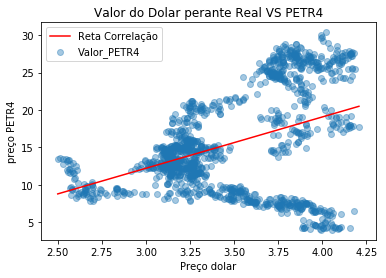

In [54]:
plt.scatter(DADOS["Valor_CRD"], DADOS["Valor_PETR4"], alpha = 0.4)
plt.title('Valor do Dolar perante Real VS PETR4')

c = DADOS["Valor_CRD"].corr(DADOS["Valor_PETR4"])

a = DADOS["Valor_CRD"].cov(DADOS["Valor_PETR4"]) / DADOS["Valor_CRD"].var()
b = DADOS["Valor_PETR4"].mean() - a*DADOS["Valor_CRD"].mean()

plt.plot((DADOS["Valor_CRD"].min(), DADOS["Valor_CRD"].max()), (a*DADOS["Valor_CRD"].min()+b, a*DADOS["Valor_CRD"].max()+b), label="Reta Correlação", color='r')

print('Correlação entre valor dolar e preço PETR4: {0}'.format(c))

plt.xlabel('Preço dolar')
plt.ylabel('preço PETR4')
plt.legend()
plt.plot()
plt.show()


Com base nos dados acima, pode-se dizer que há uma relação entre o preço das ações cotadas do dolar com o valor das ações da PETR4.

OIL

Correlação entre valor dolar e preço PETR4: 0.6042214966987647


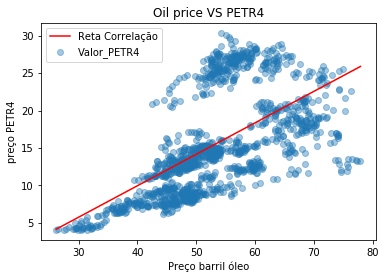

In [56]:
plt.scatter(DADOS["Valor_OIL"], DADOS["Valor_PETR4"], alpha = 0.4)
plt.title('Oil price VS PETR4')

c = DADOS["Valor_OIL"].corr(DADOS["Valor_PETR4"])

a = DADOS["Valor_OIL"].cov(DADOS["Valor_PETR4"]) / DADOS["Valor_OIL"].var()
b = DADOS["Valor_PETR4"].mean() - a*DADOS["Valor_OIL"].mean()

plt.plot((DADOS["Valor_OIL"].min(), DADOS["Valor_OIL"].max()), (a*DADOS["Valor_OIL"].min()+b, a*DADOS["Valor_OIL"].max()+b), label="Reta Correlação", color='r')

print('Correlação entre valor dolar e preço PETR4: {0}'.format(c))

plt.xlabel('Preço barril óleo')
plt.ylabel('preço PETR4')

plt.legend()
plt.plot()
plt.show()

De acordo com os dados acima, percebe-se que existe uma considerável correlação entre o preço das ações da PETR4 e do valor do barril de óleo.

RDS

Correlação entre valor dolar e preço PETR4: 0.8354337046757684


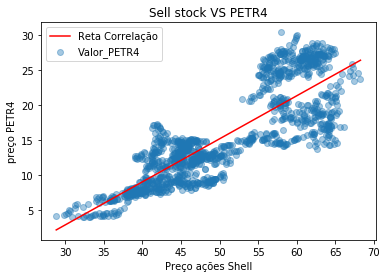

In [57]:
plt.scatter(DADOS["Valor_RDS"], DADOS["Valor_PETR4"], alpha = 0.4)
plt.title('Sell stock VS PETR4')

c = DADOS["Valor_RDS"].corr(DADOS["Valor_PETR4"])

a = DADOS["Valor_RDS"].cov(DADOS["Valor_PETR4"]) / DADOS["Valor_RDS"].var()
b = DADOS["Valor_PETR4"].mean() - a*DADOS["Valor_RDS"].mean()

plt.plot((DADOS["Valor_RDS"].min(), DADOS["Valor_RDS"].max()), (a*DADOS["Valor_RDS"].min()+b, a*DADOS["Valor_RDS"].max()+b), label="Reta Correlação", color='r')

print('Correlação entre valor dolar e preço PETR4: {0}'.format(c))

plt.xlabel('Preço ações Shell')
plt.ylabel('preço PETR4')

plt.legend()
plt.plot()
plt.show()

Com base nos dados, é possível concluir que há uma forte relação entre o preço das ações da companhia Shell e o valor das ações da PETR4.

GOLD

Correlação entre valor dolar e preço PETR4: 0.5843190099464479


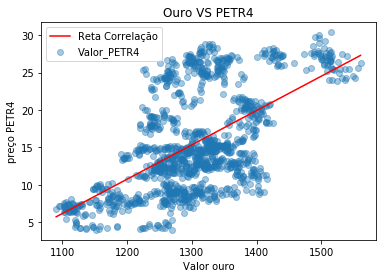

In [59]:
plt.scatter(DADOS["Valor_GOLD"], DADOS["Valor_PETR4"], alpha = 0.4)
plt.title('Ouro VS PETR4')

c = DADOS["Valor_GOLD"].corr(DADOS["Valor_PETR4"])

a = DADOS["Valor_GOLD"].cov(DADOS["Valor_PETR4"]) / DADOS["Valor_GOLD"].var()
b = DADOS["Valor_PETR4"].mean() - a*DADOS["Valor_GOLD"].mean()

plt.plot((DADOS["Valor_GOLD"].min(), DADOS["Valor_GOLD"].max()), (a*DADOS["Valor_GOLD"].min()+b, a*DADOS["Valor_GOLD"].max()+b), label="Reta Correlação", color='r')

print('Correlação entre valor dolar e preço PETR4: {0}'.format(c))

plt.xlabel('Valor ouro')
plt.ylabel('preço PETR4')

plt.legend()
plt.plot()
plt.show()

Com base no gráfico acima, é possível visualizar a existência de uma correlação entre o valor do ouro e o preço do PETR4.

**Conclusão:**

A partir dos gráficos plotados acima, podemos ratificar as hipóteses acerca de quais seriam os possíveis fatores que iriam influenciar o preço da ação da PETR4.

### Início da análise percentual da taxa de variação do PETR4

Adicionando no DataFrame a variação percentual de cada coluna:

In [16]:
i = 0
FAZER1 = []
while i < 1298:
    FAZER1.append((DADOS["Valor_GOLD"][i] - DADOS["Valor_GOLD"][i-1])/DADOS["Valor_GOLD"][i-1])    
    i+=1
    
i = 0
FAZER2 = []
while i < 1298:
    FAZER2.append((DADOS["Valor_RDS"][i] - DADOS["Valor_RDS"][i-1])/DADOS["Valor_RDS"][i-1])    
    i+=1
    
i = 0
FAZER3 = []
while i < 1298:
    FAZER3.append((DADOS["Valor_OIL"][i] - DADOS["Valor_OIL"][i-1])/DADOS["Valor_OIL"][i-1])    
    i+=1    

i = 0
FAZER4 = []
while i < 1298:
    FAZER4.append((DADOS["Valor_CRD"][i] - DADOS["Valor_CRD"][i-1])/DADOS["Valor_CRD"][i-1])    
    i+=1     
    
i = 0
FAZER5 = []
while i < 1298:
    FAZER5.append((DADOS["Valor_PETR4"][i+1] - DADOS["Valor_PETR4"][i])/DADOS["Valor_PETR4"][i])
    i+=1
    

DADOS_OPT = DADOS.iloc[1:1298,:]

del FAZER1[0]
del FAZER2[0]
del FAZER3[0]
del FAZER4[0]
del FAZER5[0]

    
DADOS_OPT['CALC_GOLD'] = FAZER1;
DADOS_OPT['CALC_RDS'] = FAZER2;
DADOS_OPT['CALC_OIL'] = FAZER3;
DADOS_OPT['CALC_CRD'] = FAZER4;
DADOS_OPT['CALC_PETR4'] = FAZER5;

DADOS_OPT.head(5)

C:\Users\jotah\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jotah\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jotah\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

,Valor_CRD,Valor_OIL,Valor_RDS,Valor_GOLD,Valor_PETR4,CALC_GOLD,CALC_RDS,CALC_OIL,CALC_CRD,CALC_PETR4
Date,,,,,,,,,,
2014-11-11,2.5575,77.94,51.477970,1255.1,13.256026,0.003037,0.005798,0.006977,0.001841,0.007857
2014-11-12,2.5665,77.18,50.531734,1250.4,13.360181,-0.003745,-0.018381,-0.009751,0.003519,-0.036145
2014-11-13,2.5889,74.21,50.179653,1251.4,12.877283,0.000800,-0.006968,-0.038481,0.008728,-0.029412
2014-11-14,2.6018,75.82,50.891159,1275.6,12.498541,0.019338,0.014179,0.021695,0.004983,-0.045455
2014-11-17,2.6081,75.64,50.795807,1273.7,11.930425,-0.001489,-0.001874,-0.002374,0.002421,-0.011905


**Gráficos de dispersão dos valores de variação percentual**

CRD

Ajuste linear entre CALC_CRD e CALC_PETR4:
Correlação entre % de variação do preço do valor do dólar para real e % de variação do PETR4 é: -0.0214154984791198


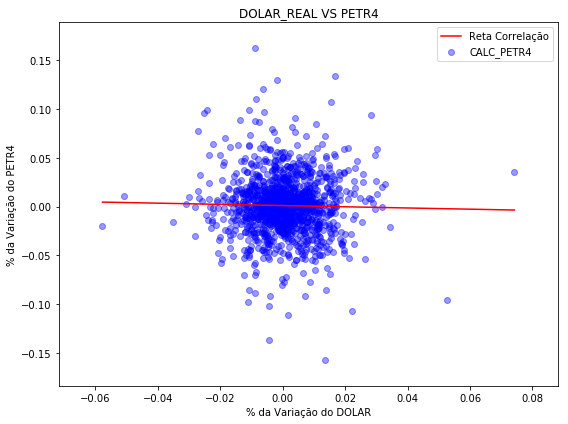

In [17]:
a = DADOS_OPT.CALC_CRD.cov(DADOS_OPT.CALC_PETR4) / DADOS_OPT.CALC_CRD.var()
b = DADOS_OPT.CALC_PETR4.mean() - a*DADOS_OPT.CALC_CRD.mean()
c = DADOS_OPT.CALC_CRD.corr(DADOS_OPT.CALC_PETR4)

print('Ajuste linear entre CALC_CRD e CALC_PETR4:')

fig = plt.figure(figsize=(8, 6))
plt.scatter(DADOS_OPT.CALC_CRD, DADOS_OPT.CALC_PETR4, c='blue', alpha=0.4)
plt.title('DOLAR_REAL VS PETR4')
plt.xlabel('% da Variação do DOLAR')
plt.ylabel('% da Variação do PETR4')

plt.plot((DADOS_OPT.CALC_CRD.min(), DADOS_OPT.CALC_CRD.max()), (a*DADOS_OPT.CALC_CRD.min()+b, a*DADOS_OPT.CALC_CRD.max()+b), label="Reta Correlação", color='red')

print('Correlação entre % de variação do preço do valor do dólar para real e % de variação do PETR4 é: {0}'.format(c))

plt.tight_layout()
plt.legend()
plt.show()

Devido a grande dispersão entre os pontos, e da taxa de correlação ser extremamente baixa, de somente -0.021, podemos concluir que a taxa de variação do DOLAR não se correlaciona de forma expressível com a taxa de variação do PETR4.

OIL

Ajuste linear entre CALC_OIL e CALC_PETR4:
Correlação entre % de variação do preço do barril de petroleo e % de variação do PETR4 é: -0.004595816532457675


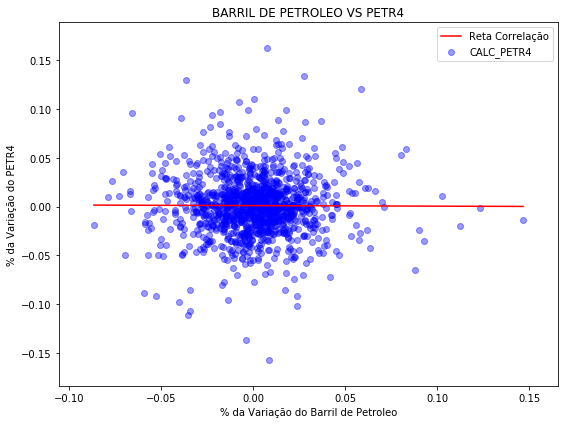

In [18]:
a = DADOS_OPT.CALC_OIL.cov(DADOS_OPT.CALC_PETR4) / DADOS_OPT.CALC_OIL.var()
b = DADOS_OPT.CALC_PETR4.mean() - a*DADOS_OPT.CALC_OIL.mean()
c = DADOS_OPT.CALC_OIL.corr(DADOS_OPT.CALC_PETR4)

print('Ajuste linear entre CALC_OIL e CALC_PETR4:')

fig = plt.figure(figsize=(8, 6))
plt.scatter(DADOS_OPT.CALC_OIL, DADOS_OPT.CALC_PETR4, c='blue', alpha=0.4)
plt.title('BARRIL DE PETROLEO VS PETR4')
plt.xlabel('% da Variação do Barril de Petroleo')
plt.ylabel('% da Variação do PETR4')

plt.plot((DADOS_OPT.CALC_OIL.min(), DADOS_OPT.CALC_OIL.max()), (a*DADOS_OPT.CALC_OIL.min()+b, a*DADOS_OPT.CALC_OIL.max()+b), label="Reta Correlação", color='red')

print('Correlação entre % de variação do preço do barril de petroleo e % de variação do PETR4 é: {0}'.format(c))

plt.tight_layout()
plt.legend()
plt.show()

Devido a grande dispersão entre os pontos, e da taxa de correlação ser extremamente baixa, de somente -0.0045, podemos concluir que a taxa de variação do valor do petróleo não se correlaciona de forma expressível com a taxa de variação do PETR4.

RDS

Ajuste linear entre CALC_RDS e CALC_PETR4:
Correlação entre % de variação das ações da Shell e % de variação do PETR4 é: 0.061792655912065036


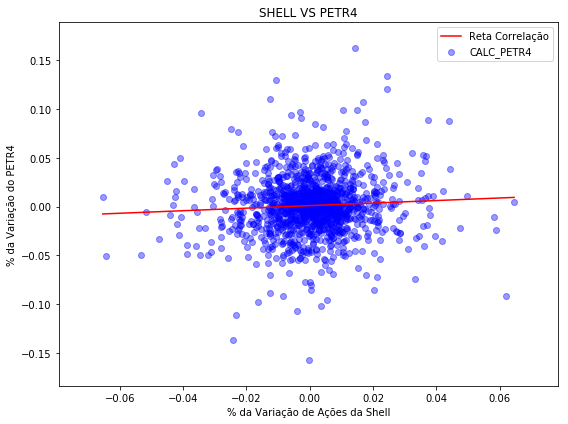

In [19]:
a = DADOS_OPT.CALC_RDS.cov(DADOS_OPT.CALC_PETR4) / DADOS_OPT.CALC_RDS.var()
b = DADOS_OPT.CALC_PETR4.mean() - a*DADOS_OPT.CALC_RDS.mean()
c = DADOS_OPT.CALC_RDS.corr(DADOS_OPT.CALC_PETR4)

print('Ajuste linear entre CALC_RDS e CALC_PETR4:')

fig = plt.figure(figsize=(8, 6))
plt.scatter(DADOS_OPT.CALC_RDS, DADOS_OPT.CALC_PETR4, c='blue', alpha=0.4)
plt.title('SHELL VS PETR4')
plt.xlabel('% da Variação de Ações da Shell')
plt.ylabel('% da Variação do PETR4')

plt.plot((DADOS_OPT.CALC_RDS.min(), DADOS_OPT.CALC_RDS.max()), (a*DADOS_OPT.CALC_RDS.min()+b, a*DADOS_OPT.CALC_RDS.max()+b), label="Reta Correlação", color='red')

print('Correlação entre % de variação das ações da Shell e % de variação do PETR4 é: {0}'.format(c))

plt.tight_layout()
plt.legend()
plt.show()

Devido a grande dispersão entre os pontos, e da taxa de correlação ser extremamente baixa, de somente 0.061, podemos concluir que a taxa de variação das ações da Shell não se correlacionam de forma expressível com a taxa de variação do PETR4.

GOLD

Ajuste linear entre CALC_GOLD e CALC_PETR4:
Correlação entre % de variação do ouro e % de variação do PETR4 é: -0.017677149966121828


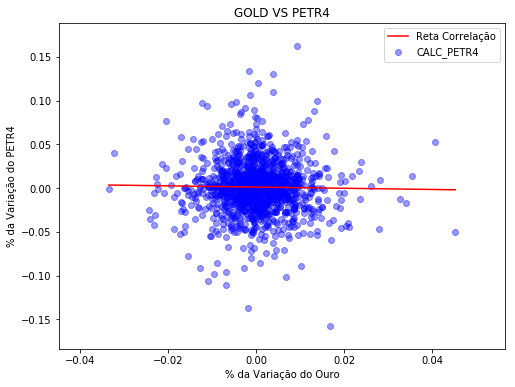

In [20]:
a = DADOS_OPT.CALC_GOLD.cov(DADOS_OPT.CALC_PETR4) / DADOS_OPT.CALC_GOLD.var()
b = DADOS_OPT.CALC_PETR4.mean() - a*DADOS_OPT.CALC_GOLD.mean()
c = DADOS_OPT.CALC_GOLD.corr(DADOS_OPT.CALC_PETR4)

print('Ajuste linear entre CALC_GOLD e CALC_PETR4:')

fig = plt.figure(figsize=(8, 6))
plt.scatter(DADOS_OPT.CALC_GOLD, DADOS_OPT.CALC_PETR4, c='blue', alpha=0.4)
plt.title('GOLD VS PETR4')
plt.xlabel('% da Variação do Ouro')
plt.ylabel('% da Variação do PETR4')

plt.plot((DADOS_OPT.CALC_GOLD.min(), DADOS_OPT.CALC_GOLD.max()), (a*DADOS_OPT.CALC_GOLD.min()+b, a*DADOS_OPT.CALC_GOLD.max()+b), label="Reta Correlação", color='red')

print('Correlação entre % de variação do ouro e % de variação do PETR4 é: {0}'.format(c))

plt.legend()
plt.plot()
plt.show()

Devido a grande dispersão entre os pontos, e da taxa de correlação ser extremamente baixa, de somente -0.017, podemos concluir que a taxa de variação do valor do ouro não se correlaciona de forma expressível com a taxa de variação do PETR4.

**Conclusão:**

A partir dos gráficos plotados acima, podemos supor que a utilização dos valores percentuais de cada ação não seriam as melhores variáveis de entrada na regressão com o PETR4, mas só poderá ser efetivamente concluida tal premissa com a análise das regressões feita posteriormente no código.

## Aplicando o modelo de regressão linear

**Ajustando a Tabela para a Regressão**

In [21]:
DADOS_OPT.columns

Index(['Valor_CRD', 'Valor_OIL', 'Valor_RDS', 'Valor_GOLD', 'Valor_PETR4',
       'CALC_GOLD', 'CALC_RDS', 'CALC_OIL', 'CALC_CRD', 'CALC_PETR4'],
      dtype='object')

Definindo nossas variáveis do nosso dataset

In [22]:
df = DADOS_OPT[['Valor_CRD', 'Valor_OIL', 'Valor_RDS', 'Valor_GOLD', 'Valor_PETR4', 'CALC_GOLD', 'CALC_RDS', 'CALC_OIL', 'CALC_CRD', 'CALC_PETR4']]

In [23]:
df.describe()

,Valor_CRD,Valor_OIL,Valor_RDS,Valor_GOLD,Valor_PETR4,CALC_GOLD,CALC_RDS,CALC_OIL,CALC_CRD,CALC_PETR4
count,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000
mean,3.476241,53.151318,50.456716,1302.706052,15.464385,0.000168,0.000225,0.000020,0.000399,0.001091
std,0.392010,9.631621,9.139196,85.301049,6.710696,0.007697,0.014236,0.023822,0.010436,0.030073
min,2.501100,26.210000,28.818090,1090.500000,3.976808,-0.033435,-0.065352,-0.086711,-0.057731,-0.157591
25%,3.179500,46.700000,42.996601,1256.500000,9.809459,-0.003888,-0.007080,-0.013350,-0.005847,-0.015305
50%,3.392600,52.410000,48.118477,1302.400000,14.155543,0.000000,0.000480,0.000750,0.000032,0.000779
75%,3.827200,59.520000,58.919838,1350.100000,20.366940,0.004172,0.007564,0.012450,0.006593,0.015326
max,4.207700,77.940000,68.253716,1560.400000,30.080000,0.045232,0.064506,0.146764,0.074251,0.162832


Verificando os valores nulos

In [24]:
np.sum(df.isnull());

Definindo nossa variável de resposta

In [25]:
Y = df['CALC_PETR4']

Definindo os outros parâmetros. Valores brutos removidos; valores relativos mais relevantes na regressão

In [26]:
X = df[['CALC_GOLD', 'CALC_RDS', 'CALC_OIL', 'CALC_CRD']]
X.head()

,CALC_GOLD,CALC_RDS,CALC_OIL,CALC_CRD
Date,,,,
2014-11-11,0.003037,0.005798,0.006977,0.001841
2014-11-12,-0.003745,-0.018381,-0.009751,0.003519
2014-11-13,0.000800,-0.006968,-0.038481,0.008728
2014-11-14,0.019338,0.014179,0.021695,0.004983
2014-11-17,-0.001489,-0.001874,-0.002374,0.002421


In [27]:
Y_valor = df['Valor_PETR4']

X_valor = df[['Valor_CRD', 'Valor_OIL', 'Valor_RDS','Valor_GOLD']]

**Separando os dados de treinamento e teste :**

Definindo o RANDOM_SEED

In [28]:
RANDOM_SEED = 42

Criando nossas variáveis de teste e treinamento

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = RANDOM_SEED)

In [30]:
X_train_valor, X_test_valor, Y_train_valor, Y_test_valor = train_test_split(X_valor, Y_valor, test_size=0.2, random_state=RANDOM_SEED)

**Função da Regressão:**

Função utilitária para fazer a regressão com constante adicionada

In [31]:
def regress(X,Y):
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results

### Início da Regressão com valores absolutos:

In [32]:
results_valor = regress(X_train_valor, Y_train_valor)
results_valor.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Valor_PETR4   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     923.4
Date:                Thu, 21 Nov 2019   Prob (F-statistic):               0.00
Time:                        23:07:06   Log-Likelihood:                -2659.5
No. Observations:                1037   AIC:                             5329.
Df Residuals:                    1032   BIC:                             5354.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -48.0968      2.100    -22.899      0.000     -52.218     -43.975
Valor_CRD      3.9517      0.291     13.600      0.000       3.381       4.522
Valor_OIL     -0.0067      0.020     -0.336      0.737      -0.046       0.032
Valor_RDS      0.4771      0.025     19.201      0.000       0.428       0.526
Valor_GOLD     0.0200      0.001     13.963      0.000       0.017       0.023
==============================================================================
Omnibus:                       11.516   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.751
Skew:                          -0.251   Prob(JB):                      0.00281
Kurtosis:                       2.862   Cond. No.                     2.82e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.82e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Adicionando uma coluna p equivaler a função regress

In [33]:
X_test_valor_n = sm.add_constant(X_test_valor)

Teste do modelo

In [34]:
y_pred_valor = results_valor.predict(X_test_valor_n)

**Avaliando o modelo**

A partir de agora será utilizada a base de teste para avaliar a acurácia do algoritmo obtido.

In [35]:
lista_pred = []
lista_Y_valor = []
acertos = 0


for e in y_pred_valor:
    lista_pred.append(e)
    
for e in Y_test_valor:
    lista_Y_valor.append(e)

# 
i = 0
while i < len(lista_pred):
    a = lista_Y_valor[i]*1.05
    b = lista_Y_valor[i]*0.95
    print(a, " - ",b)
    print(lista_pred[i])
    if lista_pred[i] < a and lista_pred[i] > b:
        acertos += 1
    i += 1
        
acc = acertos/len(lista_Y_valor)
print(acertos)
acc

15.0919881  -  13.6546559
11.404597087810213
7.555935450000001  -  6.836322549999999
10.422795597396718
15.0522183  -  13.618673699999999
15.817071266014347
26.495038500000003  -  23.971701499999998
20.387918358809664
28.542429825000003  -  25.824103175
22.862681163136024
18.32581695  -  16.58050105
21.400887501774093
13.43167035  -  12.15246365
11.778226094972773
14.61476835  -  13.22288565
12.146604944634143
21.27592215  -  19.24964385
22.87652774637389
9.34549875  -  8.45545125
11.68921497768527
14.932916250000002  -  13.51073375
15.503239649110615
29.143978500000003  -  26.3683615
22.43970456651523
13.26265605  -  11.999545949999998
13.981898555954817
12.80532225  -  11.585767749999999
12.846187251256397
19.1866269  -  17.359329099999997
22.563695637768326
8.7887457  -  7.951722299999999
10.29743542487301
8.858339700000002  -  8.0146883
11.949112255614395
13.372015650000002  -  12.098490349999999
14.675621615996759
12.775497  -  11.558783
13.549909082045001
8.31152805  -  7.5199539

0.1076923076923077

Acertos Totais

In [36]:
print(f'Os acertos totais foram {acertos} de {len(lista_Y_valor)}')

Os acertos totais foram 28 de 260


Acerto em %

In [37]:
print(f'O acerto em % foi de {acc*100}%')

O acerto em % foi de 10.76923076923077%


Com base na regressão linear obtida e a base de teste selecionada, a acurácia do modelo de predição foi de 10,77%

**Ajustando o coeficiente R-squared**

Foi removido a variável com maior P>|t|, ou seja, foi removida a variável com menor influência na taxa de variação percentual do PETR4. Desse modo se obtêm um resultado mais preciso e adequado com a realidade, por mais que o R-squared diminua minimamente. Isso ocorre pois a variável retirada utilizava uma coeficiente não condizente com a realidade para se ajustar a regressão.

* Removendo o parâmetro do preço do barril de óleo (maior P>|t|)

In [38]:
X_valor = df[['Valor_CRD', 'Valor_RDS','Valor_GOLD']]

In [39]:
X_train_valor, X_test_valor, Y_train_valor, Y_test_valor = train_test_split(X_valor, Y_valor, test_size=0.2, random_state=RANDOM_SEED)

In [40]:
results = regress(X_train_valor, Y_train_valor)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Valor_PETR4   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     1232.
Date:                Thu, 21 Nov 2019   Prob (F-statistic):               0.00
Time:                        23:07:12   Log-Likelihood:                -2659.6
No. Observations:                1037   AIC:                             5327.
Df Residuals:                    1033   BIC:                             5347.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -48.4551      1.809    -26.792      0.000     -52.004     -44.906
Valor_CRD      3.9956      0.259     15.408      0.000       3.487       4.504
Valor_RDS      0.4700      0.013     36.084      0.000       0.444       0.496
Valor_GOLD     0.0202      0.001     14.912      0.000       0.018       0.023
==============================================================================
Omnibus:                       11.548   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.803
Skew:                          -0.253   Prob(JB):                      0.00274
Kurtosis:                       2.872   Cond. No.                     2.42e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.42e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Adicionando uma coluna p equivaler a função regress

In [41]:
X_test_valor_n = sm.add_constant(X_test_valor)

Teste do modelo

In [42]:
y_pred_valor = results.predict(X_test_valor_n)

**Avaliando o modelo**

A partir de agora será utilizada a base de teste para avaliar a acurácia do algoritmo obtido.

In [43]:
lista_pred = []
lista_Y_valor = []
acertos = 0


for e in y_pred_valor:
    lista_pred.append(e)
    
for e in Y_test_valor:
    lista_Y_valor.append(e)

# 
i = 0
while i < len(lista_pred):
    a = lista_Y_valor[i]*1.05
    b = lista_Y_valor[i]*0.95
    print(a, " - ",b)
    print(lista_pred[i])
    if lista_pred[i] < a and lista_pred[i] > b:
        acertos += 1
    i += 1
        
acc = acertos/len(lista_Y_valor)
print(acc)
acertos

15.0919881  -  13.6546559
11.438364648424418
7.555935450000001  -  6.836322549999999
10.414580402839267
15.0522183  -  13.618673699999999
15.77709694710119
26.495038500000003  -  23.971701499999998
20.4222234250646
28.542429825000003  -  25.824103175
22.87180103342173
18.32581695  -  16.58050105
21.437538631452938
13.43167035  -  12.15246365
11.79854737947485
14.61476835  -  13.22288565
12.16037266118633
21.27592215  -  19.24964385
22.886521755135636
9.34549875  -  8.45545125
11.651297347181767
14.932916250000002  -  13.51073375
15.47355226853916
29.143978500000003  -  26.3683615
22.417756885876848
13.26265605  -  11.999545949999998
13.950431029610042
12.80532225  -  11.585767749999999
12.874295718686241
19.1866269  -  17.359329099999997
22.571687023648145
8.7887457  -  7.951722299999999
10.24448604562058
8.858339700000002  -  8.0146883
11.912826408518137
13.372015650000002  -  12.098490349999999
14.631848102459248
12.775497  -  11.558783
13.51918929231097
8.31152805  -  7.51995395
8.9

29

Acertos Totais

In [44]:
print(f'Os acertos totais foram {acertos} de {len(lista_Y_valor)}')

Os acertos totais foram 29 de 260


Acertos em %

In [45]:
print(f'O acerto em % foi de {acc*100}%')

O acerto em % foi de 11.153846153846155%


### Conclusão da regressão linear por valores absolutos

Apesar da regressão utilizando valores absolutos como variáveis de entrada não ter dado resultados muito baixos, ainda há espaço para melhora. Com as plotagens acima, foi possível melhorar a predição por meio da regressão linear, retirando o parâmetro que possuia a "menor influência" dentro do escopo em estudo, esse resultado pode ser observado ao analisar os acertos e consequentemente, a acurácia, obtidos com as regressões penta e tetradimensionais. Contudo, ainda pode ser explorado outros métodos capaz de satisfazer melhor a predição dos valores futuros da PETR4.

**Análise dos parâmetros individuais por meio da regressão**

A regressão feita acima correlaciona o preço da ação da PETR4 com outros 4 parâmetros, gerando uma correlação pentadimensional. Os coeficientes obtidos com a regressão, ao serem analisados bidimensionalmente com o preço da PETR4, se assemelham á correlação feita na primeira parte do código.

### Início da Regressão percentual:

Usando regressão para aplicar o ajuste

In [46]:
results = regress(X_train,Y_train)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             CALC_PETR4   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.437
Date:                Thu, 21 Nov 2019   Prob (F-statistic):             0.0456
Time:                        23:07:18   Log-Likelihood:                 2169.9
No. Observations:                1037   AIC:                            -4330.
Df Residuals:                    1032   BIC:                            -4305.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.498      0.618      -0.001       0.002
CALC_GOLD     -0.1382      0.120     -1.154      0.249      -0.373       0.097
CALC_RDS       0.2113      0.081      2.598      0.010       0.052       0.371
CALC_OIL      -0.0946      0.049     -1.937      0.053      -0.190       0.001
CALC_CRD      -0.0961      0.093     -1.032      0.302      -0.279       0.087
==============================================================================
Omnibus:                       84.060   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              425.466
Skew:                           0.124   Prob(JB):                     4.08e-93
Kurtosis:                       6.128   Cond. No.                         131.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Ajustando R-squared Para as Variáveis que Mais Influenciam o CALC_PETR4**

* Removendo a variável com maior P>|t|

Removendo CALC_CRD

In [47]:
X1 = X_train[['CALC_RDS', 'CALC_OIL', 'CALC_GOLD']]

Usando regressão para aplicar o ajuste

In [48]:
results1 = regress(X1, Y_train)
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             CALC_PETR4   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.894
Date:                Thu, 21 Nov 2019   Prob (F-statistic):             0.0343
Time:                        23:07:19   Log-Likelihood:                 2169.3
No. Observations:                1037   AIC:                            -4331.
Df Residuals:                    1033   BIC:                            -4311.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.452      0.652      -0.001       0.002
CALC_RDS       0.2237      0.080      2.781      0.006       0.066       0.382
CALC_OIL      -0.0898      0.049     -1.847      0.065      -0.185       0.006
CALC_GOLD     -0.1215      0.119     -1.024      0.306      -0.354       0.111
==============================================================================
Omnibus:                       84.989   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              439.848
Skew:                           0.115   Prob(JB):                     3.08e-96
Kurtosis:                       6.182   Cond. No.                         128.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Como se pode perceber pela análise da regressão acima, o R-squared diminuiu 0.001. Por mais que o resultado tenha dado minimamente mais baixo, o novo resultado é mais conveniente.

**Análise da Influência dos Valores**

Do mesmo modo da regressão absoluta, a percentual correlaciona o preço da ação da PETR4 com outros 4 parâmetros, gerando uma correlação pentadimensional. Os coeficientes obtidos com a regressão, ao serem analisados bidimensionalmente com o preço da PETR4, se assemelham á correlação feita na primeira parte do código.

**Treinando o Modelo**

Criando nossas variáveis preditivas

In [49]:
X_new = sm.add_constant(X_test)
y_pred = results.predict(X_new)
y_pred.head()

Date
2017-02-24   -0.004122
2016-03-09    0.003165
2017-09-19    0.003740
2018-10-22   -0.000452
2019-04-19    0.000826
dtype: float64

**Avaliando o modelo**

A partir de agora será utilizada a base de teste para avaliar a acurácia do algoritmo obtido.

In [50]:
lista_pred = []
lista_Y_valor = []
acertos = 0


for e in y_pred:
    lista_pred.append(e)
    
for e in Y_test:
    lista_Y_valor.append(e)
    
i = 0
while i < len(lista_pred):
    a = lista_Y_valor[i]*1.5
    b = lista_Y_valor[i]*0.5
    print(a, " - ",b)
    print(lista_pred[i])
    if lista_pred[i] < a and lista_pred[i] > b:
        acertos += 1
    i += 1
        
acc = acertos/len(lista_Y_valor);

0.011198907253312684  -  0.003732969084437561
-0.004121532590491916
0.06907901456463598  -  0.023026338188211995
0.0031648940005789463
0.07232506055270287  -  0.024108353517567623
0.0037396952266373546
-0.01865814990229208  -  -0.006219383300764027
-0.00045203859716233286
-0.004360430708355202  -  -0.0014534769027850674
0.0008262333658086121
-0.03269777694685523  -  -0.010899258982285078
0.001967366974411146
0.04885258183841601  -  0.01628419394613867
-0.003628503626346663
0.024489886971078834  -  0.008163295657026278
-0.0004187705141316781
0.028037560289719304  -  0.009345853429906435
0.0026373543936065356
-0.02712782182973371  -  -0.009042607276577902
-0.004334658555699904
0.0  -  0.0
0.0037682643060230918
0.004804337197819379  -  0.0016014457326064596
0.0025621468221369396
0.05059962706338919  -  0.016866542354463065
0.0003121804307283189
-0.010481204407019006  -  -0.0034937348023396687
-0.002131336327607404
0.031152639706565722  -  0.010384213235521907
0.0038081442057092806
0.04242

Acertos Totais

In [51]:
print(f'Os acertos totais foram {acertos} de {len(lista_Y_valor)}')

Os acertos totais foram 8 de 260


Acerto em %

In [52]:
print(f'O acerto em % foi de {acc*100}%')

O acerto em % foi de 3.076923076923077%


### Conclusão da regressão linear por variação percentual

Como podemos observar pelos resultados acima, o acerto de 0,03% não é satisfatótio, sendo consideravelmente pior do que a regressão por valores absolutos (como esperado). Portanto podemos afetivamente concluir a premissa inicial, de que a regressão por variação percentual do PETR4 seria consideravelmente pior do que a por variação absoluta do mesmo.

Desse modo se optou pela mudança de modelo, buscando uma melhora nos resultados, como evidenciado nos códigos que seguem.

### Preparando os dados para a utilização de modelos do Scikit Learn:

In [60]:
X = DADOS_OPT.iloc[:,5:9]
y = DADOS_OPT['CALC_PETR4']

**Separando os dados em treinamento e teste, de forma aleatória:**

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

**Iniciando o Random Forest:**

In [62]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(X_train, y_train.values.ravel());

**Aferindo a quantidade de acertos:**

A métrica utilizada para conferir se os valores previstos estão próximas do real poderia ser importado do próprio Scikit Learn metrics. Entretanto, para uma análise financeira, considerou-se mlehor a determinação de um intervalo, previamente fixado, que seria considerado correto. Esse intervalo, no caso, é 1% do valor futuro da ação (em ambas as direções).

In [63]:
predictionsrf = rf.predict(X_test)
b = []

for e in predictionsrf:
    b.append(e)
    
e =0
i = 0
while i < len(b):
    if b[i] <= (y_test[i] + 0.01) and b[i] >= (y_test[i] -0.01):
        e += 1
    i += 1
    
print (f'O Acerto foi de {round((e/len(y_test))*100, 2)}%.')

O Acerto foi de 31.54%.


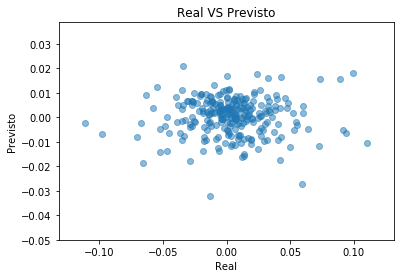

In [71]:
plt.scatter(y_test,b, alpha= 0.5)
plt.title('Real VS Previsto')
plt.xlabel("Real")
plt.ylabel("Previsto")
plt.plot()
plt.show()

Como pode ser observado, a predição do modelo não consegue condizer de forma precisa com a realidade, para tanto, uma iteração pode auxiliar.

**Iterando:**

Utilizou-se os valores brutos, pois havendo uma suposta maior correlação entre os dados, imaginava-se que o resultado seria de um acerto maior. 

In [65]:
X2 = DADOS.iloc[:,0:4]
y2 = DADOS['Valor_PETR4']

Separando os dados em treinamento e teste, de forma aleatória:

In [66]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.20)
scaler = StandardScaler()
scaler.fit(X_train)
X_train2 = scaler.transform(X_train2)
X_test2 = scaler.transform(X_test2)

Segundo modelo:

In [67]:
rf2 = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf2.fit(X_train2, y_train2.values.ravel());

Aferindo a quantidade de acertos:

In [68]:
predictionsrf2 = rf2.predict(X_test2)
b2 = []

for e in predictionsrf2:
    b2.append(e)

e =0
i2 = 0
while i2 < len(b2):
    if b2[i2] <= (y_test2[i2] + 0.01) and b2[i2] >= (y_test2[i2] - 0.01) :
        e += 1
    i2 += 1
    
print (f'O Acerto foi de {round((e/len(y_test2))*100, 2)}%.')

O Acerto foi de 1.15%.


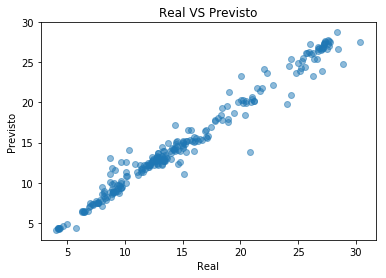

In [70]:
plt.scatter(y_test2,b2, alpha= 0.5)
plt.title('Real VS Previsto')
plt.xlabel("Real")
plt.ylabel("Previsto")
plt.plot()
plt.show()

Nessa segunda iteração, apesar do gráfico apresentar um suposto resultado melhor, o indice de acertos diminuiu significativamente indo para 3.85%.

    

## Implementando o modelo de Rede Neural

Para garantir que o modelo não aprenda a interpolar os dados, será utilizado como treinamento os dados de 2014 até 2016, e o restante, como teste:

In [ ]:
X3_train = DADOS_OPT.iloc[:800,5:9]
y3_train = DADOS_OPT['CALC_PETR4'].iloc[:800,]
X3_test = DADOS_OPT.iloc[800:,5:9]
y3_test = DADOS_OPT['CALC_PETR4'].iloc[800:,]

In [ ]:
scaler = StandardScaler()
scaler.fit(X3_train)
X3_train = scaler.transform(X3_train)
X3_test = scaler.transform(X3_test)

In [ ]:
mlp1 = MLPRegressor(hidden_layer_sizes = (440, 890, 36),alpha = 1e-6, max_iter = 1000, tol = 1e-6, random_state = 42, n_iter_no_change=40)
mlp1.fit(X3_train, y3_train.values.ravel())

Aferindo a quantidade de acertos:

In [ ]:
predictionsmlp1 = mlp1.predict(X3_test)

b3 = []
for e in predictionsmlp1:
    b3.append(e)

e =0
i3 = 0
while i3 < len(b3):
    if b3[i3] <= (y3_test[i3] + 0.01) and b3[i3] >= (y3_test[i3] - 0.01) :
        e += 1
    i3 += 1
    
print (f'O Acerto foi de {round((e/len(y3_test))*100, 2)}%.')

É possível observar que a quantidade de acertos da rede neural é menor do que a da primeira iteração do Random Forest. Para tanto, a mudança de hyperparametros é adequada. Justamente para buscar os mehores, será implementada o RandomizedSearchCV.

Iterando:

Para achar os Hyperparamtes que otimizam o modelo, será utilizado o RandomSearchcv do Scikit Learn:

In [ ]:
mlp2 = MLPRegressor (max_iter=1000)

param_distributions = {'hidden_layer_sizes': [(random.randint(1,1300), random.randint(1,1300), random.randint(1,1300), random.randint(1,1300), random.randint(1,1300))],
    'activation': ['identity','logistic','tanh'],
    'solver': ['lbfgs','sgd', 'adam'],
    'alpha': [1e-5],
    'learning_rate': ['constant','adaptive'],
    'tol' : [1e-5],
    'n_iter_no_change' : [30]    
}

g = RandomizedSearchCV(mlp2, param_distributions, n_iter=100, scoring= 'r2',cv = 10, n_jobs=None, verbose=2, random_state=42, error_score='raise-deprecating')
g.fit(X3_train, y3_train)

In [ ]:
# Best paramete set
print('Best parameters found:\n', g.best_params_)

# All results
means = g.cv_results_['mean_test_score']
stds = g.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, g.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

In [1]:
mlp3 = MLPRegressor(hidden_layer_sizes = (555, 394, 603, 256, 493),alpha = 1e-5, activation = 'logistic', solver = 'sgd', learning_rate = 'constant', max_iter = 1000, tol = 1e-5, random_state = 42, n_iter_no_change=20)
mlp3.fit(X3_train, y3_train.values.ravel()) 

NameError: name 'MLPRegressor' is not defined

Aferindo a quantidade de acertos:

In [ ]:
predictionsmlp3 = mlp3.predict(X3_test)

b4 = []
for e in predictionsmlp3:
    b4.append(e)

e =0
i4 = 0
while i4 < len(b4):
    if b4[i4] <= (y3_test[i4] + 0.01) and b4[i4] >= (y3_test[i4] - 0.01) :
        e += 1
    i4 += 1
print (f'O Acerto foi de {round((e/len(y3_test))*100, 2)}%.')  

Análise:
    
    

O modelo conseguiu prever o valor correto em 40% dos casos, um resultado considerável.

# Conclusão Final

Com base nos modelos estudados, o método eleito, que obteve maior qualidade, em termos de acertividade, na predição de valores futuros das ações da PETR4, foi a Rede Neural, capaz de prever corretamente 40% dos valores da ação da PETR4 definidas pela base de teste.
Antes de chegar a esse modelo, foram realizadas duas regressões lineares, cada qual utilizou duas variações diferentes de análise do preço das ações, sendo a primeira com os valores absolutos (preço da ação no dia-a-dia) e a segunda com a taxa de variação percentual das ações. No primeiro modelo, obteve-se um coeficiente R aceitável, mas o índice de acerto do algorítimo não estava bom o suficiente para prever o preço da companhia na bolsa. Apesar da tentativa de melhorar o coeficiente, os acertos não obtiveram um incremento siginificativo e assim foi testado uma regressão com a taxa de variação percentual das ações. Nesse segundo modelo, o resultado também não atingiu as expectativas.
Depois de tentar prever com a regressão linear, outros modelos foram executados, como o Random Forest que também não conseguiu corresponder ás predições desejadas e então foi realizado a Rede Neural, que após diversas iterações, principalmente de parâmetros exigidos pelos comandos do código, chegou-se a um desempenho aceitável de predição do algorítimo.

# Referências :

Acesso entre 14 e 21 de Novembro de 2019:

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

https://datascience.stackexchange.com/questions/36049/how-to-adjust-the-hyperparameters-of-mlp-classifier-to-get-more-perfect-performa

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

https://stackabuse.com/introduction-to-neural-networks-with-scikit-learn/

https://www.python-course.eu/neural_networks_with_scikit.php